# 3. Classifier interpretability

In this section we train two types of models: a decision tree, and a convolutional neural network, to inspect "which model is more interpretable?".

In the following steps:

1. Process the CIFAR-10 dataset.
2. Define and train a convolutional neural network (CNN) classifier using PyTorch.
3. Interpret the CNN using the 'activation maximization' technique.
4. Define and train a decision tree classifier.
5. Interpret the decision tree and

**Run the code below** to import required packages.


In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

Load data

Srource: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [2]:
def load_data(root='datasets/'):

    # normalize values from [0, 1] to [-1, 1]
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    batch_size = 5

    trainset = torchvision.datasets.CIFAR10(root=root, train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=root, train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)    

    
    return trainloader, testloader



# Get the train_oader and testloader
trainloader, testloader = load_data()


Files already downloaded and verified
Files already downloaded and verified


### Define methods to read, unpickles the data batches and convert them into np arrays for training and testing. 

In [3]:
def unpickle(filepath, filename):
    """
    read the file and return the file contents
    
    @param filepath: file relative path
    @param filename: file name
    """
    with open(os.path.join(filepath, filename), 'rb') as fo:            
        file = pickle.load(fo, encoding='bytes')
    return file

def get_train_test():

    # the folder path where it stores the CIFAR-10 training batches files
    data_path = 'datasets/cifar-10-batches-py'
        
    # file names for training batches
    training_batches = ('data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5')        
       
    # temporary variables for reading files
    train_data = None
    train_labels = None
        
    for filename in training_batches:
        # read the file contents
        dict_train = unpickle(data_path, filename)
        file_data = dict_train[b'data']
        
        file_labels = dict_train[b'labels']
            
        # append the file contents in each batch to train_data and train_labels
        if train_data is None and train_labels is None:
            # for the first training batch
            train_data = file_data
            train_labels = file_labels
        else:

            # for the following training batches
            #Stack arrays in sequence vertically (row wise) using vstack
            # This is equivalent to concatenation along the 
            # first axis after 1-D arrays of shape (N,) have been reshaped to (1,N). 
            train_data = np.vstack((train_data, file_data))
            # stack arrays in sequence horizontally (column wise) using hstack
            train_labels = np.hstack((train_labels, file_labels))
    x_train = train_data      # (50000, 3072)
    y_train = train_labels    # (50000,)
    
    # read test batch file
    test_batch = 'test_batch'
    
    # read the file contents
    dict_test = unpickle(data_path, test_batch)
        
    x_test = dict_test[b'data']      # (10000, 3072)
    y_test = dict_test[b'labels']    # (10000,)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test();

In [4]:
x_train, y_train, x_test, y_test = get_train_test()

**Run the code cell below** to do Cross validation using GridSearch over the hyper-parameters: criterion and max_depth to find the best Decision Tree classifier:

Running the following code cell takes about 9 minues on a Unix platform.

In [ ]:
# define a decision tree classifier
#To obtain a deterministic behaviour during fitting, random_state has to be fixed to an integer
dec_tree = DecisionTreeClassifier(random_state=0)
# define parameters range
params = {'max_depth': [2,4,6,8], 'criterion': ['gini', 'entropy']}
#params = dict(dec_tree__criterion=criterion, dec_tree__max_depth=max_depth)

# apply grid search cross validation
cv_grid = GridSearchCV(estimator=dec_tree, 
                       cv=3,    # 3-fold cross-validation
                       n_jobs=-1,    # use all processors to train
                       param_grid=params)

cv_grid.fit(x_train, y_train)

# get the best estimator
gridcv_best_estimator = cv_grid.best_estimator_

# print the results (Accuracy and Recall scores(macro because all classes need to be treated equally))
print('Best GridSearch estimator: ', gridcv_best_estimator)

print('Accuracy on the 50000 train images: %.2f %%' 
      % (100 * gridcv_best_estimator.score(X=x_train, y=y_train)))
print('Accuracy on the 10000 test images: %.2f %%' 
      % (100 * gridcv_best_estimator.score(X=x_test, y=y_test)))
print("Recall (average='macro') on the 50000 train images: %.3f" 
      % (recall_score(y_true=y_train, y_pred=gridcv_best_estimator.predict(x_train), average='macro')))
print("Recall (average='macro') on the 10000 test images: %.3f" 
      % (recall_score(y_true=y_test, y_pred=gridcv_best_estimator.predict(x_test), average='macro')))

**Run the code cell below** to plot the best tree:

In [ ]:
tree_depth = gridcv_best_estimator.get_depth()
plt.figure(figsize=(20,8), dpi=300)

plot_tree(decision_tree=gridcv_best_estimator,
        max_depth=2,    # only plot the top plot_depth layers
        rotate=True,
        fontsize=8)
plt.title('decision tree classifier (depth = ' + str(tree_depth) + ')')
plt.show()

**Run the code cell below**, which will take about a minute, to instanciate, train and print the classification report of the 'best' decision:

In [ ]:
# Instanciate the best decition tree (max_depth=8, criterion='gini')
dt_best = DecisionTreeClassifier(max_depth=8, random_state=0, criterion='gini')
# train the best decision tree
dt_best.fit(x_train, y_train)
# print the classification report
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classification_report(y_test, dt_best.predict(x_test), target_names=classes))

### Define Class Names

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

#### Display a sample image in the proper format

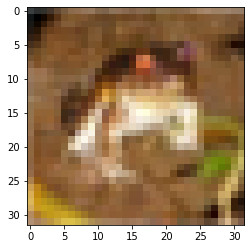

In [6]:
plt.imshow(x_train[0].reshape((3, 32, 32)).transpose(1, 2, 0))
plt.show()

Define, train and save a CNN classifier using any architecture you like, but keep trying until you achieve at least 75% accuracy on the CIFAR test images. Train using CrossEntropyLoss. 

## Define a Covolutional Neural Network

Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 in channels (one for each RGB), 6 out channels, and a kernel size of 5.
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Get the maximum feature in 2x2 kernel window and down scale the rest.
        self.pool = nn.MaxPool2d(2, 2)
        # 6 input channels (from previous 6 out), 16 out channels, and a kernel size of 5.
        self.conv2 = nn.Conv2d(6, 16, 5)
        # input features = 16 output from conv2 * (5x5) kernel size. Outputs 120 features.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # input 120 features from fc1, outputs 84 features.
        self.fc2 = nn.Linear(120, 84)
        # input 84 features from fc2, outputs 10 features.
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # relu activation function converts negative values to 0 on conv1, conv2, fc1 and fc2.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten input to a 1 d tensor
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


## Define loss function

In [8]:
# Returns the loss and optimization functions
def loss_function(network, learning_rate=0.001, weight_decay=1e-3):
    # Function to compute loss between result and target
    cel = nn.CrossEntropyLoss()
    #  Stochastic Gradient Descent taking iterator of network object's parameters, ...
    # learning rate, and momentum(convergence rate of SGD)

    # using a small learning rate, our weights decay gradually with each epoch.
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, weight_decay=weight_decay)
    return cel, optimizer

## Train the model

In [9]:
# epochs, amount of times to go over and train the data.
def train(file_name, network, criterion, optimizer, epochs = 2, data=trainloader):
    # Used to decay the learning rate after every epoch using gamma as a multiplicitive factor.
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 

    # Loop over training for each epoch.
    for epoch in range(epochs): 
        loss_tracker = 0.0
        network.train()
        for i, images in enumerate(data, 0):
            # split 'images' based on list [inputs, labels]
            inputs, labels = images

            # Set optimizer gradients to 0
            optimizer.zero_grad()

            # Calls the 'forward' function of network
            outputs = network(inputs)
            # Calculate the loss from the forward results
            loss = criterion(outputs, labels)

            # Take the gradient of loss.
            loss.backward()
            
            # Update Model Params.
            optimizer.step()

            # print statistics
            loss_tracker += loss.item()
            if i % 1000 == 999:    # print every 1000 mini-batches
                print('[Epoch: %d, Data seen: %5d] loss: %.3f' %
                      (epoch + 1, i + 1, loss_tracker / 1000))
                loss_tracker = 0.0
        
        ## Save the model state after epoch
        network.eval() 
        torch.save(network.state_dict(), file_name+str(epoch+1)+'.pt')
        scheduler.step()
        

    print('Finished Training')

## Save the model

In [10]:
def save_model(network, learning_rate=0.001, epochs=2):
    PATH = './TrainedModels/'+ str(learning_rate)+'_'+str(epochs)+'.pth'
    torch.save(network.state_dict(), PATH)
    print("File saved")
    return PATH

### Main function to run the CNN

In [11]:
# Returns the saved path if save=True, else return none.
# file_name refers to the prefex for each model epoch to be save to.
def run_CNN(file_name, learning_rate=0.001, epochs=2, save=False, data=trainloader, weight_decay=1e-3):
    network = Network()
    cel, opt = loss_function(network, learning_rate, weight_decay=weight_decay)
    train(file_name, network, cel, opt, epochs, data)
    if save:
        return save_model(network, learning_rate, epochs)
        

### Run the Network

In [ ]:
model_path = run_CNN('TrainedModels/model_', epochs=30, learning_rate=0.01, weight_decay=1e-3, save=True)

[Epoch: 1, Data seen:  1000] loss: 2.271
[Epoch: 1, Data seen:  2000] loss: 2.058
[Epoch: 1, Data seen:  3000] loss: 1.931
[Epoch: 1, Data seen:  4000] loss: 1.793
[Epoch: 1, Data seen:  5000] loss: 1.695
[Epoch: 1, Data seen:  6000] loss: 1.608
[Epoch: 1, Data seen:  7000] loss: 1.568
[Epoch: 1, Data seen:  8000] loss: 1.529
[Epoch: 1, Data seen:  9000] loss: 1.513
[Epoch: 1, Data seen: 10000] loss: 1.506
[Epoch: 2, Data seen:  1000] loss: 1.434
[Epoch: 2, Data seen:  2000] loss: 1.435
[Epoch: 2, Data seen:  3000] loss: 1.418
[Epoch: 2, Data seen:  4000] loss: 1.383
[Epoch: 2, Data seen:  5000] loss: 1.370
[Epoch: 2, Data seen:  6000] loss: 1.334
[Epoch: 2, Data seen:  7000] loss: 1.350
[Epoch: 2, Data seen:  8000] loss: 1.329
[Epoch: 2, Data seen:  9000] loss: 1.298
[Epoch: 2, Data seen: 10000] loss: 1.287
[Epoch: 3, Data seen:  1000] loss: 1.247
[Epoch: 3, Data seen:  2000] loss: 1.258
[Epoch: 3, Data seen:  3000] loss: 1.213
[Epoch: 3, Data seen:  4000] loss: 1.206
[Epoch: 3, Data 

### Print method for a batch

In [59]:
def imshow(img):
    # Reverse normalization
    img = img / 2 + 0.5    
    # set tensor to numpy array
    img = img.numpy()
    # set channels to proper formal
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

## Evaluate the CNN above on the test images

### Method to Graph the accuracy of the model over each epoch.

In [60]:
# Epochs to take into account
def accuracy_on_epoch(epoch, title, augmented=False ):    
    accuracys = []
    base_path = './TrainedModels/model_'
    if augmented:
        base_path = './TrainedModels/augmented_model_'
    for i in range(epoch):
        loaded_network = Network()
        loaded_network.load_state_dict(torch.load(base_path+str(i+1)+'.pt'))
        # Trackers for functions.
        correct = 0
        total = 0

        # Compare true values to model prediction.
        with torch.no_grad():
            # Taking batches
            for data in testloader:
                images, labels = data
                outputs = loaded_network(images)
                # Take highest class score as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracys.append(correct / total)
    # Plot results        
    epochs = [i+1 for i in range(epoch)]            
    plt.plot(epochs, accuracys)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()

### Evaluate Model accuracy

In [61]:
def eval_model(title, epoch, augmented=False):
    # Classes Trackers for scoring
    # correct refers to true poitive guess for a class 
    correct = {class_name: 0 for class_name in class_names}
    # wrong refers to a false positive guess for a class
    wrong = {class_name: 0 for class_name in class_names}
    # True count for a class
    total = {class_name: 0 for class_name in class_names}

    base_path = './TrainedModels/model_'
    if augmented:
        base_path = './TrainedModels/augmented_model_'
    loaded_network = Network()
    loaded_network.load_state_dict(torch.load(base_path+str(epoch)+'.pt'))


    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = loaded_network(images)
            _, predictions = torch.max(outputs, 1)

            # count the correct predicitons for each class 
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct[class_names[label]] += 1
                else: wrong[class_names[label]] += 1
                total[class_names[label]] += 1


    # Print results for each class 
    for class_name, correct_count in correct.items():
        
        # Calculate Precision, Recall and F-score
        precision = 100 * correct_count/(correct_count + wrong[class_name])
        recall = 100 * correct_count/(correct_count +  total[class_name])
        f_score = 2*precision*recall/(precision + recall)
        print("Class {:5s}  Precision: {:.2f} % Recall: {:.2f} % F-Score: {:.2f}".format(class_name, precision, recall, f_score))

    
    print('\nAccuracy: {:.2f} %'.format(100 * sum([correct[i] for i in correct]) / sum([total[i] for i in total])))


    accuracy_on_epoch(epoch, title, augmented=True, )

In [64]:
eval_model("Accuracy per epoch", 30, augmented=False)

### Data Augmentation

In [65]:
# Create new data based on mirrored versions of each image, rotated images, and mirrored + rotated sets.
new_data = []
for i, data in enumerate(trainloader):
    images, labels = data
    flip_1 = torch.rot90(images, k=1, dims=(2,3))
    new_data.append([images, labels])
    mirror = torch.flip(images, [3])
    mirror2 = torch.flip(flip_1, [3])
    new_data.append([mirror, labels])
    new_data.append([flip_1, labels])
    new_data.append([mirror2, labels])


### Train the Model using the augmented dataset

In [45]:
model_path = run_CNN(epochs=30, save=True, learning_rate=0.01, data=new_data, weight_decay=1e-3)

[Epoch: 1, Data seen:  1000] loss: 2.293
[Epoch: 1, Data seen:  2000] loss: 2.102
[Epoch: 1, Data seen:  3000] loss: 1.945
[Epoch: 1, Data seen:  4000] loss: 1.770
[Epoch: 1, Data seen:  5000] loss: 1.647
[Epoch: 1, Data seen:  6000] loss: 1.702
[Epoch: 1, Data seen:  7000] loss: 1.664
[Epoch: 1, Data seen:  8000] loss: 1.660
[Epoch: 1, Data seen:  9000] loss: 1.633
[Epoch: 1, Data seen: 10000] loss: 1.612
[Epoch: 1, Data seen: 11000] loss: 1.578
[Epoch: 1, Data seen: 12000] loss: 1.539
[Epoch: 1, Data seen: 13000] loss: 1.526
[Epoch: 1, Data seen: 14000] loss: 1.483
[Epoch: 1, Data seen: 15000] loss: 1.483
[Epoch: 1, Data seen: 16000] loss: 1.482
[Epoch: 1, Data seen: 17000] loss: 1.523
[Epoch: 1, Data seen: 18000] loss: 1.497
[Epoch: 1, Data seen: 19000] loss: 1.438
[Epoch: 1, Data seen: 20000] loss: 1.410
[Epoch: 1, Data seen: 21000] loss: 1.421
[Epoch: 1, Data seen: 22000] loss: 1.329
[Epoch: 1, Data seen: 23000] loss: 1.374
[Epoch: 1, Data seen: 24000] loss: 1.350
[Epoch: 1, Data 

[Epoch: 6, Data seen:  1000] loss: 1.020
[Epoch: 6, Data seen:  2000] loss: 0.993
[Epoch: 6, Data seen:  3000] loss: 1.013
[Epoch: 6, Data seen:  4000] loss: 1.033
[Epoch: 6, Data seen:  5000] loss: 0.948
[Epoch: 6, Data seen:  6000] loss: 0.995
[Epoch: 6, Data seen:  7000] loss: 0.990
[Epoch: 6, Data seen:  8000] loss: 1.031
[Epoch: 6, Data seen:  9000] loss: 1.030
[Epoch: 6, Data seen: 10000] loss: 1.024
[Epoch: 6, Data seen: 11000] loss: 0.993
[Epoch: 6, Data seen: 12000] loss: 0.981
[Epoch: 6, Data seen: 13000] loss: 1.001
[Epoch: 6, Data seen: 14000] loss: 0.949
[Epoch: 6, Data seen: 15000] loss: 0.992
[Epoch: 6, Data seen: 16000] loss: 0.994
[Epoch: 6, Data seen: 17000] loss: 1.028
[Epoch: 6, Data seen: 18000] loss: 1.021
[Epoch: 6, Data seen: 19000] loss: 1.007
[Epoch: 6, Data seen: 20000] loss: 0.978
[Epoch: 6, Data seen: 21000] loss: 0.975
[Epoch: 6, Data seen: 22000] loss: 0.925
[Epoch: 6, Data seen: 23000] loss: 0.996
[Epoch: 6, Data seen: 24000] loss: 0.971
[Epoch: 6, Data 

[Epoch: 10, Data seen: 40000] loss: 0.896
[Epoch: 11, Data seen:  1000] loss: 0.919
[Epoch: 11, Data seen:  2000] loss: 0.885
[Epoch: 11, Data seen:  3000] loss: 0.921
[Epoch: 11, Data seen:  4000] loss: 0.938
[Epoch: 11, Data seen:  5000] loss: 0.849
[Epoch: 11, Data seen:  6000] loss: 0.919
[Epoch: 11, Data seen:  7000] loss: 0.897
[Epoch: 11, Data seen:  8000] loss: 0.941
[Epoch: 11, Data seen:  9000] loss: 0.913
[Epoch: 11, Data seen: 10000] loss: 0.911
[Epoch: 11, Data seen: 11000] loss: 0.868
[Epoch: 11, Data seen: 12000] loss: 0.883
[Epoch: 11, Data seen: 13000] loss: 0.896
[Epoch: 11, Data seen: 14000] loss: 0.866
[Epoch: 11, Data seen: 15000] loss: 0.881
[Epoch: 11, Data seen: 16000] loss: 0.884
[Epoch: 11, Data seen: 17000] loss: 0.933
[Epoch: 11, Data seen: 18000] loss: 0.921
[Epoch: 11, Data seen: 19000] loss: 0.909
[Epoch: 11, Data seen: 20000] loss: 0.898
[Epoch: 11, Data seen: 21000] loss: 0.881
[Epoch: 11, Data seen: 22000] loss: 0.817
[Epoch: 11, Data seen: 23000] loss

[Epoch: 15, Data seen: 36000] loss: 0.862
[Epoch: 15, Data seen: 37000] loss: 0.845
[Epoch: 15, Data seen: 38000] loss: 0.861
[Epoch: 15, Data seen: 39000] loss: 0.862
[Epoch: 15, Data seen: 40000] loss: 0.849
[Epoch: 16, Data seen:  1000] loss: 0.858
[Epoch: 16, Data seen:  2000] loss: 0.854
[Epoch: 16, Data seen:  3000] loss: 0.868
[Epoch: 16, Data seen:  4000] loss: 0.890
[Epoch: 16, Data seen:  5000] loss: 0.796
[Epoch: 16, Data seen:  6000] loss: 0.877
[Epoch: 16, Data seen:  7000] loss: 0.854
[Epoch: 16, Data seen:  8000] loss: 0.908
[Epoch: 16, Data seen:  9000] loss: 0.866
[Epoch: 16, Data seen: 10000] loss: 0.855
[Epoch: 16, Data seen: 11000] loss: 0.817
[Epoch: 16, Data seen: 12000] loss: 0.830
[Epoch: 16, Data seen: 13000] loss: 0.850
[Epoch: 16, Data seen: 14000] loss: 0.832
[Epoch: 16, Data seen: 15000] loss: 0.840
[Epoch: 16, Data seen: 16000] loss: 0.839
[Epoch: 16, Data seen: 17000] loss: 0.876
[Epoch: 16, Data seen: 18000] loss: 0.874
[Epoch: 16, Data seen: 19000] loss

[Epoch: 20, Data seen: 32000] loss: 0.814
[Epoch: 20, Data seen: 33000] loss: 0.797
[Epoch: 20, Data seen: 34000] loss: 0.757
[Epoch: 20, Data seen: 35000] loss: 0.810
[Epoch: 20, Data seen: 36000] loss: 0.831
[Epoch: 20, Data seen: 37000] loss: 0.808
[Epoch: 20, Data seen: 38000] loss: 0.830
[Epoch: 20, Data seen: 39000] loss: 0.813
[Epoch: 20, Data seen: 40000] loss: 0.813
[Epoch: 21, Data seen:  1000] loss: 0.832
[Epoch: 21, Data seen:  2000] loss: 0.822
[Epoch: 21, Data seen:  3000] loss: 0.844
[Epoch: 21, Data seen:  4000] loss: 0.869
[Epoch: 21, Data seen:  5000] loss: 0.773
[Epoch: 21, Data seen:  6000] loss: 0.854
[Epoch: 21, Data seen:  7000] loss: 0.810
[Epoch: 21, Data seen:  8000] loss: 0.877
[Epoch: 21, Data seen:  9000] loss: 0.845
[Epoch: 21, Data seen: 10000] loss: 0.820
[Epoch: 21, Data seen: 11000] loss: 0.790
[Epoch: 21, Data seen: 12000] loss: 0.801
[Epoch: 21, Data seen: 13000] loss: 0.818
[Epoch: 21, Data seen: 14000] loss: 0.803
[Epoch: 21, Data seen: 15000] loss

[Epoch: 25, Data seen: 28000] loss: 0.796
[Epoch: 25, Data seen: 29000] loss: 0.832
[Epoch: 25, Data seen: 30000] loss: 0.807
[Epoch: 25, Data seen: 31000] loss: 0.802
[Epoch: 25, Data seen: 32000] loss: 0.795
[Epoch: 25, Data seen: 33000] loss: 0.777
[Epoch: 25, Data seen: 34000] loss: 0.733
[Epoch: 25, Data seen: 35000] loss: 0.792
[Epoch: 25, Data seen: 36000] loss: 0.807
[Epoch: 25, Data seen: 37000] loss: 0.790
[Epoch: 25, Data seen: 38000] loss: 0.807
[Epoch: 25, Data seen: 39000] loss: 0.789
[Epoch: 25, Data seen: 40000] loss: 0.791
[Epoch: 26, Data seen:  1000] loss: 0.814
[Epoch: 26, Data seen:  2000] loss: 0.804
[Epoch: 26, Data seen:  3000] loss: 0.820
[Epoch: 26, Data seen:  4000] loss: 0.852
[Epoch: 26, Data seen:  5000] loss: 0.758
[Epoch: 26, Data seen:  6000] loss: 0.838
[Epoch: 26, Data seen:  7000] loss: 0.781
[Epoch: 26, Data seen:  8000] loss: 0.856
[Epoch: 26, Data seen:  9000] loss: 0.828
[Epoch: 26, Data seen: 10000] loss: 0.807
[Epoch: 26, Data seen: 11000] loss

[Epoch: 30, Data seen: 24000] loss: 0.769
[Epoch: 30, Data seen: 25000] loss: 0.802
[Epoch: 30, Data seen: 26000] loss: 0.808
[Epoch: 30, Data seen: 27000] loss: 0.787
[Epoch: 30, Data seen: 28000] loss: 0.781
[Epoch: 30, Data seen: 29000] loss: 0.820
[Epoch: 30, Data seen: 30000] loss: 0.804
[Epoch: 30, Data seen: 31000] loss: 0.791
[Epoch: 30, Data seen: 32000] loss: 0.789
[Epoch: 30, Data seen: 33000] loss: 0.766
[Epoch: 30, Data seen: 34000] loss: 0.728
[Epoch: 30, Data seen: 35000] loss: 0.783
[Epoch: 30, Data seen: 36000] loss: 0.795
[Epoch: 30, Data seen: 37000] loss: 0.777
[Epoch: 30, Data seen: 38000] loss: 0.797
[Epoch: 30, Data seen: 39000] loss: 0.772
[Epoch: 30, Data seen: 40000] loss: 0.777
Finished Training
File saved


### Accuracy of model trained on expanded data

Class airplane  Precision: 68.80 % Recall: 40.76 % F-Score: 51.19
Class automobile  Precision: 74.80 % Recall: 42.79 % F-Score: 54.44
Class bird   Precision: 41.30 % Recall: 29.23 % F-Score: 34.23
Class cat    Precision: 45.90 % Recall: 31.46 % F-Score: 37.33
Class deer   Precision: 59.30 % Recall: 37.23 % F-Score: 45.74
Class dog    Precision: 51.60 % Recall: 34.04 % F-Score: 41.02
Class frog   Precision: 76.70 % Recall: 43.41 % F-Score: 55.44
Class horse  Precision: 66.20 % Recall: 39.83 % F-Score: 49.74
Class ship   Precision: 74.20 % Recall: 42.59 % F-Score: 54.12
Class truck  Precision: 76.60 % Recall: 43.37 % F-Score: 55.39

Accuracy: 63.54 %


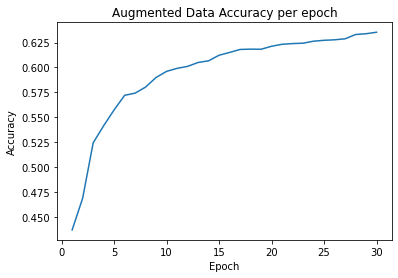

In [31]:
eval_model("Augmented Data Accuracy per epoch", 30, augmented=True)

 ## Required functions for activation maximization

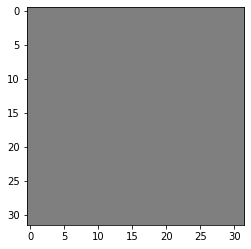

RuntimeError: expected scalar type Char but found Float

<Figure size 1152x1008 with 0 Axes>

In [180]:
def activation_maximization(model, image, target, labels, num_iter=1, learning_rate=0.2):
    model.eval() 

    # zero the gradients
    model.zero_grad()

    for i in range(num_iter):
        # get the activation results of 10 output neurons
        model.float()
        activations = model(image)

        # get the activation of the target class neuron
        target_activation = activations[0, target]
        target_activation.backward()

        # update the image
        image.data += learning_rate * image.grad

        # zero the gradients
        image.grad.zero_()

    # return tuned image
    return image
base_img = torch.from_numpy(np.zeros(shape=(1, 3, 32, 32), dtype=np.byte))
normalize = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

# Normalize grey image

# base_img[0] = normalize(base_img[0])
                                



# Show initial grey image.
imshow(base_img[0])
# Make a base for each class
airplane = torch.max(torch.tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 1)[1]
automobile = torch.max(torch.tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]), 1)[1]
bird = torch.max(torch.tensor([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]]), 1)[1]
cat = torch.max(torch.tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]), 1)[1]
deer = torch.max(torch.tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]), 1)[1]
dog = torch.max(torch.tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]), 1)[1]
frog = torch.max(torch.tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]), 1)[1]
horse = torch.max(torch.tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]), 1)[1]
ship = torch.max(torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]), 1)[1]
truck = torch.max(torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]), 1)[1]
classes = [airplane, automobile, bird, cat, deer,dog,frog, horse, ship, truck]


# Load the model 
loaded_network = Network()
loaded_network.load_state_dict(torch.load('TrainedModels/augmented_model_20.pt'))

fig = plt.figure(figsize=(16, 14))
rows = 3
columns = 4
idx = 1
for cl in classes:
    # get a new initial grey image tensor
    image_tensor = base_img
    
    # perturb the grey image and try to maximize the
    tuned_image = activation_maximization(loaded_network, image_tensor, cl, y_train, num_iter=30, learning_rate=0.01)
    # show the class activation map
    fig.add_subplot(rows, columns, idx)
    show_image = inverse_normalize(tuned_image)
    imshow(show_image, title='activation image forclass \'' + labels[target] + '\'')
    idx += 1

